# Export to GDS file

[GDS](https://en.wikipedia.org/wiki/GDSII) is a binary file format used to represent planar geometric shapes, text labels, and other information about integrated circuits layout in hierarchical form. The GDS file generation is usually the last step in the photonic design workflow. This tutorial shows how to export `Tidy3D` simulations to `GDS` files. 

<img src="img/export_to_gds.png" alt="GDS layout image" width="400"/>

To import existing GDS files into Tidy3D simulations refer to the [Importing GDS files](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/GDSImport.html) tutorial. If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. 

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import gdstk
import os

# tidy3d import
import tidy3d as td
from tidy3d import web

## Directional Coupler

In this first example, we will create a directional coupler (DC) simulation and export it to GDS. To define the DC geometry we will use a function presented in the [Defining common integrated photonic components](https://www.flexcompute.com/tidy3d/examples/notebooks/PICComponents/) tutorial.

In [2]:
# Directional coupler function.
def directional_coupler(
    x0,
    y0,
    z0,
    wg_width,
    wg_thickness,
    wg_spacing_in,
    wg_spacing_coup,
    wg_length,
    coup_length,
    bend_length,
    medium,
    sidewall_angle=0,
):

    """
    This function defines a directional coupler and returns the tidy3d structure of it.

    Parameters
    ----------
    x0: x coordinate of directional coupler center (um)
    y0: y coordinate of directional coupler center (um)
    z0: z coordinate of directional coupler center (um)
    wg_width: width of the waveguide (um)
    wg_thickness: thickness of the waveguide (um)
    wg_spacing_in : spacing between the input straight waveguides (um)
    wg_spacing_coup: gap size of the coupling region (um)
    wg_length: length of the input straight waveguides (um)
    coup_length：length of the coupling region (um)
    bend_length: length of the bending (um)
    medium: medium of the waveguide
    sidewall_angle: side wall angle of the waveguide (rad)
    """

    cell = gdstk.Cell("dc")  # define a gds cell

    # define a path
    coup = gdstk.RobustPath(
        (-wg_length - bend_length - coup_length / 2 + x0, wg_spacing_in / 2 + y0),
        wg_width,
        layer=1,
        datatype=0,
    )

    coup.segment((-bend_length - coup_length / 2 + x0, wg_spacing_in / 2 + y0))

    A = (wg_spacing_in - wg_spacing_coup - wg_width) / 4

    coup.segment(
        (-coup_length / 2 + x0, wg_spacing_in / 2 + y0),
        offset=lambda u: A * np.cos(np.pi * u) - A,
    )

    coup.segment((coup_length / 2 + x0, wg_spacing_in / 2 + y0))

    coup.segment(
        (bend_length + coup_length / 2 + x0, wg_spacing_in / 2 + y0),
        offset=lambda u: -A * np.cos(np.pi * u) - A,
    )
    coup.segment(
        (wg_length + bend_length + coup_length / 2 + x0, wg_spacing_in / 2 + y0)
    )

    # add path to the cell
    cell.add(coup)

    # add the mirrored path to the cell
    cell.add(coup.copy().mirror((x0 + 1, y0), (x0, y0)))

    # define geometry from the gds cell
    dc_geo = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(z0 - wg_thickness / 2, z0 + wg_thickness / 2),
        sidewall_angle=sidewall_angle,
    )

    # define tidy3d structure of the bend
    dc = td.Structure(geometry=td.GeometryGroup(geometries=dc_geo), medium=medium)

    return dc

## Simulation Setup

The waveguides material is silicon and the surrounding medium is silica. The simulation wavelength ranges from 1.5 $\mu m$ to 1.6 $\mu m$. 

In [3]:
# Materials definition.
mat_si = td.Medium(permittivity=3.47**2)
mat_sio2 = td.Medium(permittivity=1.44**2)
mat_gold = td.material_library["Au"]["JohnsonChristy1972"]

# Wavelengths
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.5, 1.6, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency range

Now, we will build the simulation including the DC structure, a mode source, and a field monitor. The DC structure is only for demonstration purposes, so it is not intended to be optimized. Two gold pads are included to illustrate the separation of different mediums in layers. 

In [4]:
# Create the DC structure.
dc = directional_coupler(
    x0=0,
    y0=0,
    z0=0,
    wg_spacing_in=10,
    wg_width=0.50,
    wg_thickness=0.22,
    wg_spacing_coup=0.1,
    coup_length=5,
    bend_length=6,
    wg_length=10,
    medium=mat_si,
    sidewall_angle=0,
)

# Two gold pads for illustration purpose.
sq_up = td.Structure(
    geometry=td.Box(center=(0, 3, 0), size=(4, 2, 0.22)),
    medium=mat_gold,
)

sq_dw = td.Structure(
    geometry=td.Box(center=(0, -3, 0), size=(4, 2, 0.22)),
    medium=mat_gold,
)

# Add a mode source as excitation.
mode_spec = td.ModeSpec(num_modes=1, target_neff=3.47)
mode_source = td.ModeSource(
    center=(-10, 5, 0),
    size=(0, 2, 1.5),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# Add a field monitor to visualize field distribution.
field_monitor = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

# construct simulation
sim = td.Simulation(
    center=(0, 0, 0),
    size=(21, 14, 2),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
    structures=[dc, sq_up, sq_dw],
    sources=[mode_source],
    monitors=[field_monitor],
    run_time=1e-12,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=mat_sio2,
)

Let's visualize the simulation and verify if all the components are in their correct places.

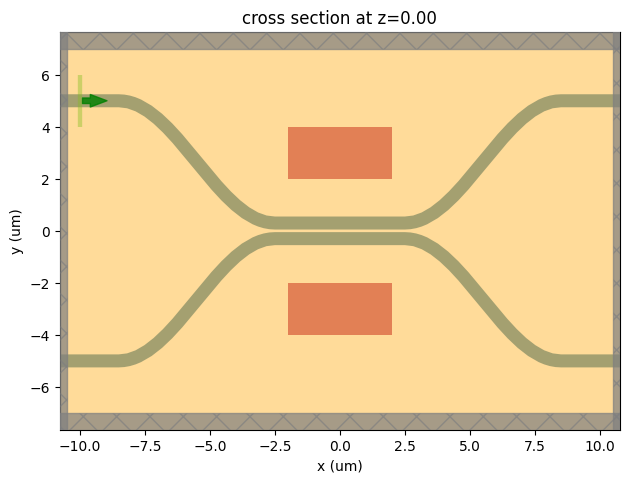

In [5]:
ax = sim.plot(z=0)
ax.set_xlabel("x (um)")
ax.set_ylabel("y (um)")
plt.show()

## Run the Simulation

For completeness, you can uncomment the lines below and run the simulation before exporting it to GDS. However, it is worth mentioning that it is not even necessary. Once you build the simulation object, you can create the GDS file from it.

In [6]:
# sim_data = web.run(
#    simulation=sim, task_name="dc_gds_export", path="data/simulation_data.hdf5"
# )

In [7]:
# sim_data.plot_field(field_monitor_name="field", field_name="E", val="abs")
# plt.show()

## Export to GDS

The Simulation object has the [.to_gds_file](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.Simulation.html#tidy3d.Simulation.to_gds_file) convenience function to export the final design to a `GDS` file. This function has the following parameters:
- `fname`: Full path to the `.gds` file to save the Simulation slice to.
- `x`: Position of plane in x-direction. 
- `y`: Position of plane in y-direction.
- `z`: Position of plane in z-direction.
- `permittivity_threshold`: Permitivitty value used to define the shape boundaries for structures with custom medium.
- `frequency`: Frequency for permittivity evaluaiton in case of custom medium (Hz).
- `gds_layer_dtype_map`: Dictionary mapping mediums to GDSII layer and data type tuples.
- `gds_cell_name`: Name of the cell created in the `.gds` file to store the geometry.

Note that only one of `x`, `y`, or `z` coordinates must be specified to define the exporting plane. In this case, we will set a `xy` plane through the `z = 0` coordinate. We have assigned the `mat_si` medium to layer `(0, 0)` and `mat_gold` to layer `(1, 0)`.

In [8]:
sim.to_gds_file(
    fname="./misc/dc_export_gds.gds",
    z=0,
    gds_cell_name="DC",
    gds_layer_dtype_map={mat_si: [0, 0], mat_gold: [1, 0]},
)

See the [Inverse design optimization of a compact grating coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin6GratingCoupler/) tutorial for an example on exporting simulations which include a custom medium.